# Signal Processing

The notebook goes into more detail on the processing of the 12 ECG data per patient. First, the signal itself is considered and then the ECG signal processing methods integrated in the 'wfdb' module are explored. Various approaches are then used to normalize the data and reduce noise in order to make the signals as comparable as possible.

In [2]:
from matplotlib import pyplot as plt
import wfdb.processing
import sys
import json
import scipy
import numpy as np

sys.path.append('../scripts')
import data_helper

## Load Data

In [3]:
data = data_helper.load_data(only_demographic=False)

print("Number of patients per category:")
for cat_name in data.keys():
    print(f"{cat_name}: {len(data[cat_name])}")

Reading SB
Reading AFIB
Reading GSVT
Reading SR
Number of patients per category:
SB: 16559
AFIB: 9839
GSVT: 948
SR: 9720


Load the parameters needed to filter the data

In [4]:
with open('../filter_params.json', 'r') as f:
    filter_params = json.load(f)

In [10]:
example_data = data['SB'][0]
sig_channel= 0

Filter the data

In [6]:
filtered_data = data_helper.filter_data(example_data, filter_params)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 544 1114 1683 2281 2855 3452 4016 4606]


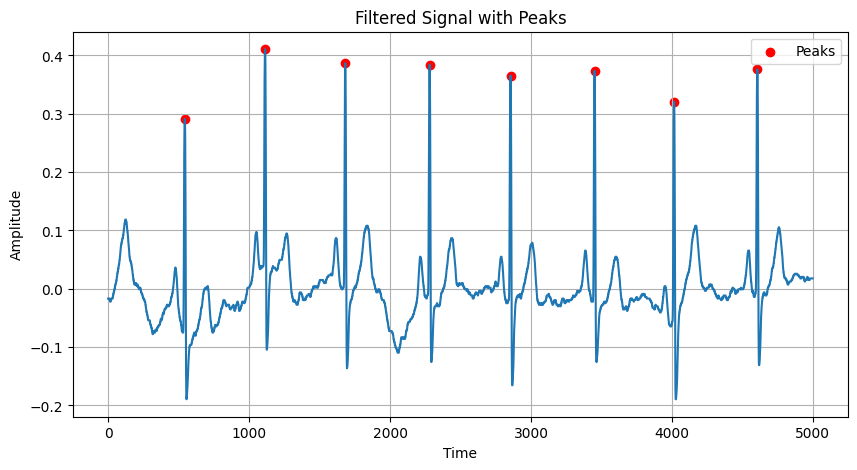

In [11]:
# Normalize data by setting qrs peaks to index position 0 (“X-axis normalization”)
indicies = wfdb.processing.xqrs_detect(filtered_data.p_signal[:,sig_channel],example_data.fs,0,5000)
print(indicies)

peak_points_y = [filtered_data.p_signal[:,sig_channel][i] for i in indicies] 

plt.figure(figsize=(10, 5))
plt.plot(filtered_data.p_signal[:,sig_channel])
plt.scatter(indicies, peak_points_y, color='red', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered XQRS Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

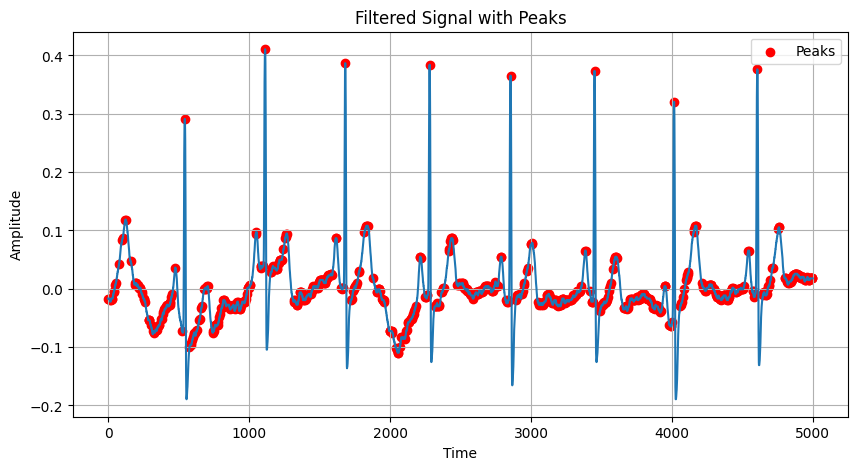

In [13]:
indicies =  wfdb.processing.find_local_peaks(filtered_data.p_signal[:,sig_channel],radius=3) 
peak_points_y = [filtered_data.p_signal[:,sig_channel][i] for i in indicies] 

plt.figure(figsize=(10, 5))
plt.plot(filtered_data.p_signal[:,sig_channel])
plt.scatter(indicies, peak_points_y, color='red', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

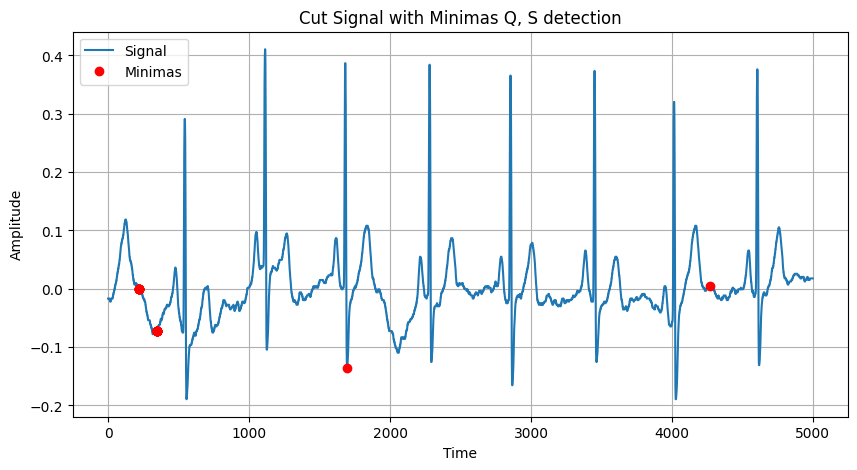

[]


In [14]:
plt.figure(figsize=(10, 5))
plt.plot(filtered_data.p_signal[:,sig_channel])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cut Signal with Minimas Q, S detection')
plt.grid(True)

for peak in indicies:
    start_idx = 20
    end_idx = 25
    signal_section = filtered_data.p_signal[:,sig_channel][peak-start_idx:peak+end_idx]
    minimas = scipy.signal.argrelextrema(signal_section, comparator=np.less, order=5)
    
    # map the minimas to the original signal
    minimas = minimas[0] + peak - start_idx
    minimas_y = [filtered_data.p_signal[:,sig_channel][i] for i in minimas]
    # if minimas more than 2 take those with biggest difference in y
    if len(minimas) > 2:
        minimas_y = [filtered_data.p_signal[:,sig_channel][i] for i in minimas]
        minimas_y = sorted(minimas_y)
        minimas_y = minimas_y[:2]
        minimas = [minimas[i] for i in range(0,2)]

    # plot the minimas
    plt.plot(minimas, minimas_y, 'ro')

plt.legend(['Signal', 'Minimas'])
plt.show()

#print y values of minimas
print(minimas_y)

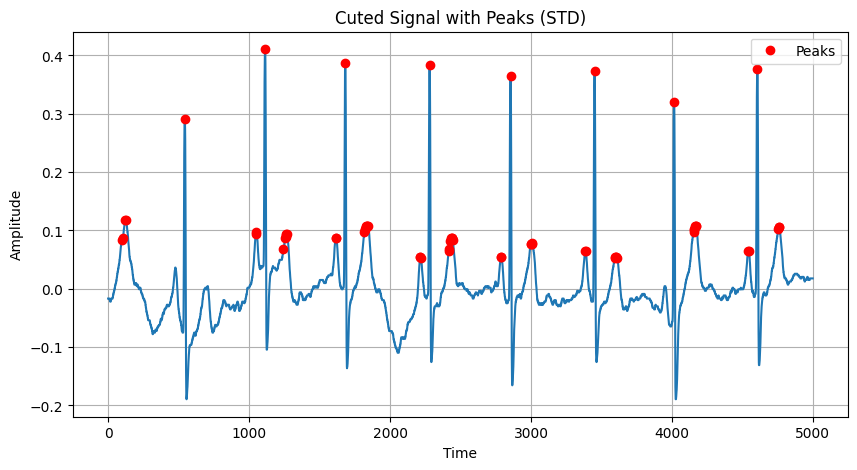

In [20]:
# find peaks in the cut signal
hard = wfdb.processing.find_local_peaks(filtered_data.p_signal[:,sig_channel],radius=3)
#peak_points_y = [cut_signal[i] for i in hard]

tolerance = 1
# get standard deviation of the hard peaks
std = filtered_data.p_signal[:,sig_channel][hard].std() * tolerance
mean = np.mean(filtered_data.p_signal[:,sig_channel])

#hard = [i for i in hard if abs(filtered_data.p_signal[:,sig_channel][i] - mean) > std]
# filter peaks with std
hard = [i for i in hard if filtered_data.p_signal[:,sig_channel][i] > std]
# get the y values of the peaks
peak_points_y = [filtered_data.p_signal[:,sig_channel][i] for i in hard]

plt.figure(figsize=(10, 5))
plt.plot(filtered_data.p_signal[:,sig_channel])
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Cuted Signal with Peaks (STD)')
plt.legend()
plt.grid(True)
plt.show()

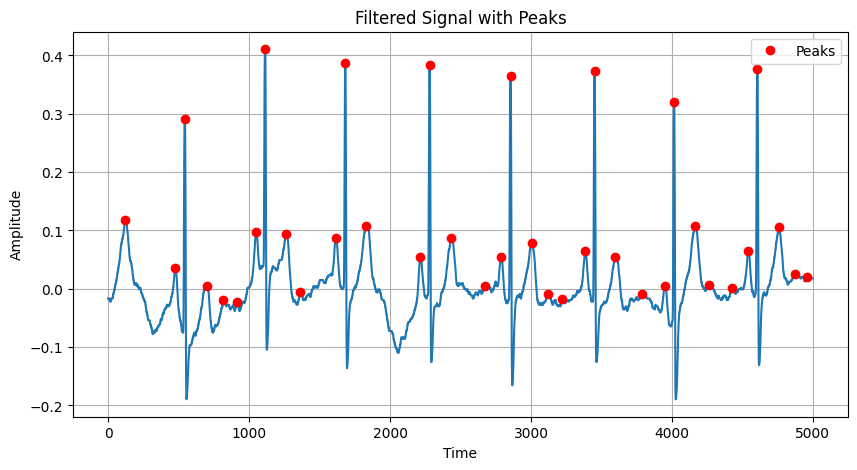

In [16]:
#Find peaks in Channel 6 of Record 25
hard = wfdb.processing.find_local_peaks(filtered_data.p_signal[:,sig_channel],radius=50)
record = filtered_data.p_signal[:,sig_channel]
peak_points_y = [record[i] for i in hard] 

plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()

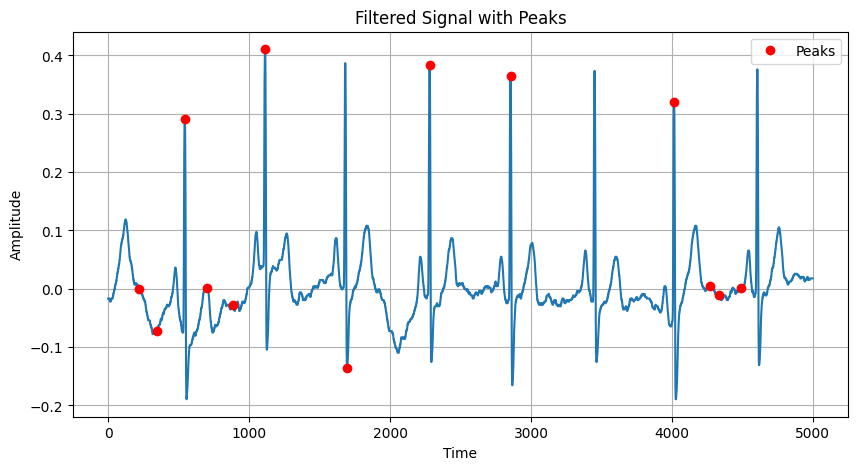

In [17]:
#Find peaks in Channel 6 of Record 25
hard, soft = wfdb.processing.find_peaks(filtered_data.p_signal[:,sig_channel])
record = filtered_data.p_signal[:,sig_channel]
peak_points_y = [record[i] for i in hard] 

plt.figure(figsize=(10, 5))
plt.plot(record)
plt.plot(hard, peak_points_y, 'ro', label='Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.legend()
plt.grid(True)
plt.show()